<a href="https://colab.research.google.com/github/kennardmah/house-price-prediction/blob/main/AP5_Cleaned_and_Balanced_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [350]:
# import all libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import sklearn.tree as tree
import graphviz
import pylab



In [351]:
# read original dataset and create dataframe object
hdf = pd.read_csv('kc_house_data.csv')
hdf = pd.DataFrame(hdf)

# hdf.info()



In [352]:
# remove variables we do not plan to use
hdf = hdf.drop(columns=['id','date','zipcode'])

# separate continous and categorical variables
continuous_hdf = hdf[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']]
categorical_hdf = hdf.drop(columns=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15'])

# restitch dataset but now with all continuous variables together
hdf = pd.concat([continuous_hdf, categorical_hdf], axis=1)

# hdf.to_csv('kc_house_reorganised.csv')




In [353]:
# make variables view, grade, condition binarised
hdf['view_b'] = hdf['view'] > 2
hdf['view_b'] = hdf['view_b'].astype(int)
hdf['condition_b'] = hdf['condition'] > 3
hdf['condition_b'] = hdf['condition_b'].astype(int)
hdf['grade_b'] = hdf['grade'] > 7
hdf['grade_b'] = hdf['grade_b'].astype(int)

# function to combine year built and year renovated into one binarised variable to see if house has been updated or created after 2000
def label_new(row):
    if row['yr_renovated'] > 2000 :
        return '1'
    elif row['yr_built'] > 2000 :
        return '1'
    else:
        return '0'

hdf['is_new_or_renovated'] = hdf.apply(lambda row: label_new(row), axis=1)
hdf['is_new_or_renovated'] = hdf['is_new_or_renovated'].astype(int)

# print(hdf['is_new_or_renovated'])

# remove original unbinarised data columns
hdf = hdf.drop(columns=['view','grade','condition','yr_built','yr_renovated'])

# create a copy of the dataframe with price column removed
price_pd = pd.DataFrame(hdf.copy().pop('price'))

# convert price into a categorical variable with 10 appropriate ranges based on typical housing prices USD
price_lab = ['A', 'B', 'C', 'D', 'E']
price_pd['price_range'] = pd.cut(price_pd.price, [0, 300000, 400000, 500000, 700000, 8000000], labels=price_lab)
print(price_pd)







          price price_range
0      221900.0           A
1      538000.0           D
2      180000.0           A
3      604000.0           D
4      510000.0           D
...         ...         ...
21608  360000.0           B
21609  400000.0           B
21610  402101.0           C
21611  400000.0           B
21612  325000.0           B

[21613 rows x 2 columns]


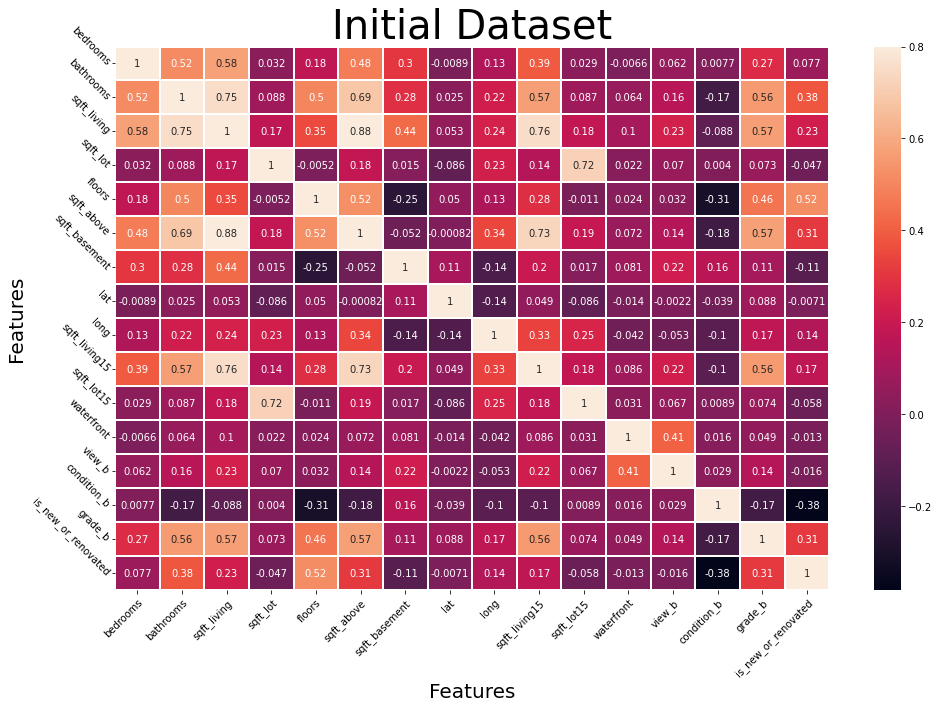

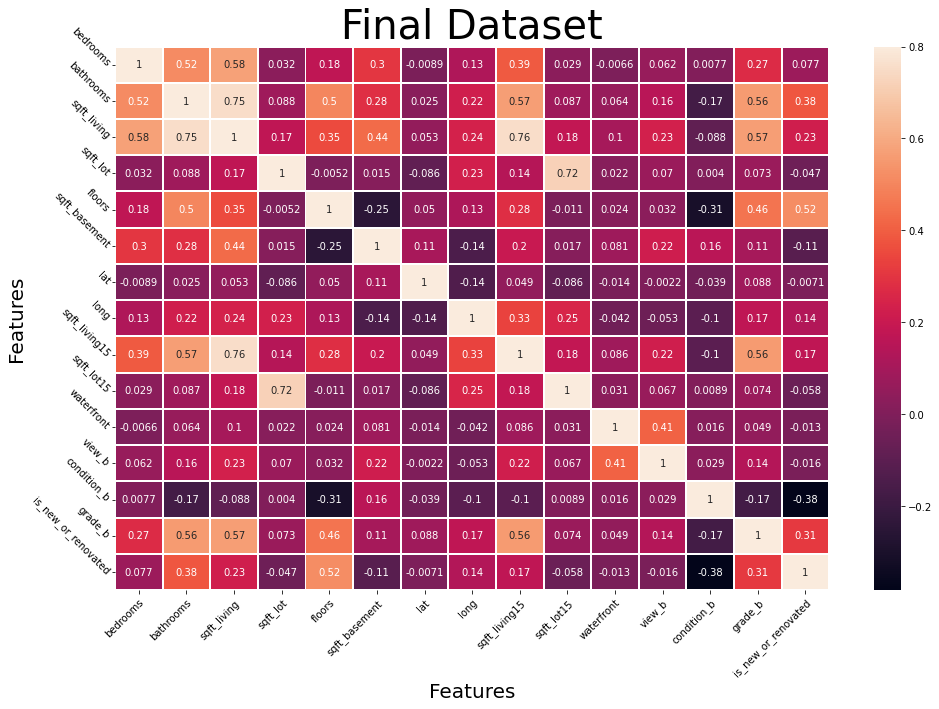

In [354]:
# dataframe copy for correlation matrix
hdf_corr = hdf.copy()

# create attributes axis for correlation matrix
columns = list(hdf_corr.columns)
y_col = columns.pop(0)
y = hdf_corr[y_col].to_numpy()
X = hdf_corr[columns].to_numpy()

scaler = MinMaxScaler()
hdf_corr[columns] = scaler.fit_transform(hdf_corr[columns])

# remove price to see correlations between other attributes
hdf_corr = hdf_corr.drop(['price'], axis=1)

# defines and creates initial correlation matrix
corrmat = hdf_corr.corr()
fig, ax = plt.subplots(figsize=[16,10])
sns.heatmap(corrmat,vmax=0.8, annot=True, linewidths=1, linecolor='white')
ax.set_xlabel('Features', fontsize = 20)    
ax.set_ylabel('Features', fontsize =20)
plt.title("Initial Dataset", fontsize = 40)  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.setp(ax.get_yticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.show()

# There is a high correlation between sqft_living and sqft_above (0.88) so it was removed to reduce skew
hdf_corr = hdf_corr.drop(['sqft_above'], axis=1)
# defines and creates final correlation matrix, where correlations of magnitude greate than 0.8 were removed
corrmat = hdf_corr.corr() 
fig, ax = plt.subplots(figsize=[16,10])
sns.heatmap(corrmat,vmax=0.8, annot=True, linewidths=1, linecolor='white')
ax.set_xlabel('Features', fontsize = 20)    
ax.set_ylabel('Features', fontsize =20)
plt.title("Final Dataset", fontsize = 40)  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.setp(ax.get_yticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.show()

corrT = hdf_corr.corr(method = 'pearson').round(4)
# corrT = corrT.sort_values(by=['price'])
# corrT['price']

# print(hdf)

In [355]:
# dataframe copy for preprocessing
hdf_prepro = hdf.copy()
# add categorical price variable
hdf_prepro['Price Range'] = price_pd['price_range']
# remove columns no longer needed
hdf_prepro = hdf_prepro.drop(['sqft_above', 'price'], axis=1)


In [356]:
hdf_prepro['Price Range'].value_counts()

D    4730
A    4570
E    4323
B    4269
C    3721
Name: Price Range, dtype: int64

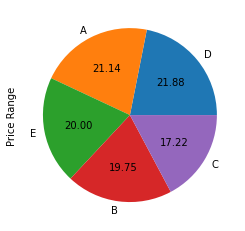

In [357]:
hdf_prepro['Price Range'].value_counts().plot.pie(autopct = '%.2f')

In [358]:
# create csv of processed data
hdf_prepro.to_csv("KC_House_Processed_Data.csv")

In [359]:
# creates training, validation, and test sets with 80/10/10
train, other = train_test_split(hdf_prepro, test_size=0.2, random_state=0)
validation, test = train_test_split(other, test_size=0.5, random_state=0)

# X sets include all attributes except price range, y sets are just price range
X_train = train.drop(['Price Range'], axis = 1)
y_train = train['Price Range']
X_val = validation.drop(['Price Range'], axis = 1)
y_val = validation['Price Range']
X_test = test.drop(['Price Range'], axis = 1)
y_test = test['Price Range']
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,3,1.0,1570,5510,1.0,500,47.6942,-122.319,1770,6380,0,0,1,0,0
16909,3,2.5,1780,11000,1.0,570,47.5574,-122.149,2310,9700,0,0,1,1,0
16123,3,1.5,1090,9862,1.0,0,47.6256,-122.036,1710,9862,0,0,0,1,0
12181,4,2.5,2210,7079,2.0,0,47.4206,-122.183,1970,7000,0,0,0,1,0
12617,3,2.5,1800,4763,2.0,560,47.6460,-122.362,1790,4763,0,0,0,0,0


In [360]:
# standardising (normalising) the data so that the mean=0 and std=1, helps to balance data along with the previous binarisation of some features
means = X_train.mean(axis=0)
stds = X_train.std(axis=0)

X_train_standardised = (X_train - means) / stds
X_val_standardised = (X_val - means) / stds
X_test_standardised = (X_test - means) / stds

X_train_standardised.head()
# print(X_train_standardised['sqft_living'].std())
# print(X_test_standardised['sqft_living'].mean())

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,-0.390023,-1.448095,-0.553934,-0.230230,-0.917914,0.466341,0.964830,-0.744673,-0.316901,-0.232451,-0.090673,-0.200307,1.395306,-0.961610,-0.549848
16909,-0.390023,0.494282,-0.326475,-0.100351,-0.917914,0.624130,-0.022009,0.463181,0.469978,-0.112885,-0.090673,-0.200307,1.395306,1.039863,-0.549848
16123,-0.390023,-0.800636,-1.073840,-0.127273,-0.917914,-0.660724,0.469968,1.266049,-0.404332,-0.107050,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12181,0.670275,0.494282,0.139273,-0.193112,0.925056,-0.660724,-1.008849,0.221611,-0.025464,-0.210123,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12617,-0.390023,0.494282,-0.304813,-0.247902,0.925056,0.601588,0.617128,-1.050189,-0.287757,-0.290686,-0.090673,-0.200307,-0.716647,-0.961610,-0.549848


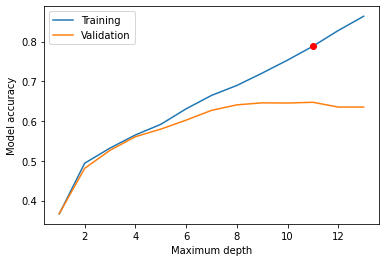

11


In [361]:
'''method to calculate max_depth of decision tree
    same depth will be used for random forest max depth'''
max_depth = range(1,14) 
t_score = []
v_score = []
d_out = 0

for d in max_depth:
  dtree = tree.DecisionTreeClassifier(random_state=1, max_depth=d) 
  dtree.fit(np.asarray(X_train_standardised), y_train) 
  v_score.append(accuracy_score(y_val, dtree.predict(np.asarray(X_val_standardised)))) 
  t_score.append(accuracy_score(y_train, dtree.predict(np.asarray(X_train_standardised)))) 
  if (d_out == 0) & (d>2):
    if (t_score[-1]/t_score[-2] < 1.001) | (np.mean(v_score[-3:]) < np.mean(v_score[-4:-1])): 
      d_out = d-1


plt.plot(max_depth, t_score, label='Training') 
plt.plot(max_depth, v_score, label='Validation') 
plt.plot(d_out, t_score[d_out-1],'or') 
plt.legend()
plt.xlabel('Maximum depth') 
plt.ylabel('Model accuracy') 
plt.show()
print(d_out)

In [362]:

# initialises and trains random forest using standardised training set
rfc  = RandomForestClassifier(max_depth=11, min_samples_split=20)
rfc = rfc.fit(X_train_standardised, y_train)

# uses model to predict price range category
ypred_val = rfc.predict(X_val_standardised)
ypred_test = rfc.predict(X_test_standardised)

# calculates performance metrics for validation set
acc_val = accuracy_score(y_val, ypred_val)
prec_val = precision_score(y_val, ypred_val, average='weighted', zero_division=0)
rec_val = recall_score(y_val, ypred_val, average='weighted')

# calculates performance metrics for test set
acc_test = accuracy_score(y_test, ypred_test)
prec_test = precision_score(y_test, ypred_test, average='weighted', zero_division=0)
rec_test = recall_score(y_test, ypred_test, average='weighted')

# prints performance metrics
print('Validation Precision:{}'.format(prec_val))
print('Validation Accuracy:{}'.format(acc_val))
print('Validation Recall:{}'.format(rec_val))
print('Test Precision:{}'.format(prec_test))
print('Test Accuracy:{}'.format(acc_test))
print('Test Recall:{}'.format(rec_test))



Validation Precision:0.6787432854580945
Validation Accuracy:0.6788523831559463
Validation Recall:0.6788523831559463
Test Precision:0.6827486374113071
Test Accuracy:0.6803885291396855
Test Recall:0.6803885291396855


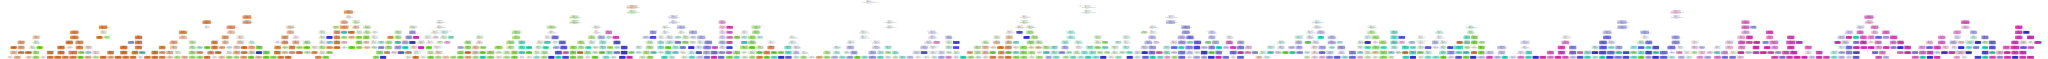

In [363]:
# creates visualization of random forest tree
estimator = rfc.estimators_[5]
dot_data = tree.export_graphviz(estimator, out_file=None)
graph = graphviz.Source(dot_data)

predictors = X_train_standardised.columns
dot_data = tree.export_graphviz(estimator, out_file=None,
                                feature_names = predictors,
                                class_names = ('A', 'B', 'C', 'D', 'E'),
                                filled = True, rounded = True,
                                special_characters = True)
graph = graphviz.Source(dot_data)  
graph 

# import pydotplus

# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('original_tree.png')
# pydot_graph.set_size('"150,150!"')
# pydot_graph.write_png('resized_tree.png')

In [364]:
def RandForest(hdf_prepro: pd.DataFrame) -> pd.DataFrame:
  ''' Takes a dataset as a dataframe and trains a Random Forest Classifier, returns predicted values and test values'''
  rfc = RandomForestClassifier(max_depth = 11, min_samples_split = 20)
  columns=list(hdf_prepro.columns)
  index=columns.index("Price Range")
  y_col = columns.pop(index)
  y = hdf_prepro[y_col].to_numpy()
  X = hdf_prepro[columns].to_numpy()
  train, other = train_test_split(hdf_prepro, test_size=0.2, random_state=0)
  validation, test = train_test_split(other, test_size=0.5, random_state=0)
  
  X_train = train.drop(['Price Range'], axis = 1)
  y_train = train['Price Range']
  X_val = validation.drop(['Price Range'], axis = 1)
  y_val = validation['Price Range']
  X_test = test.drop(['Price Range'], axis = 1)
  y_test = test['Price Range']
  means = X_train.mean(axis=0)
  stds = X_train.std(axis=0)
  X_train_standardised = (X_train - means) / stds
  X_test_standardised = (X_test - means) / stds
  rfc = rfc.fit(X_train_standardised, y_train)
  pred  = rfc.predict(X_test_standardised)
  return pred, y_test


In [365]:
def conf_matrix(ytest: np.ndarray, predict: np.ndarray) -> pd.DataFrame:
    '''Creates a confusion matrix and normalises with the sum of the matrix and returns the normalized matrix'''
    
    price_brack = ['A', 'B', 'C', 'D', 'E']
    conf_matrix= confusion_matrix(ytest, predict, labels=price_brack)
    conf_matrixper = conf_matrix/np.sum(conf_matrix)
    conf_matrixper = pd.DataFrame(conf_matrixper, index=price_brack, columns=price_brack)
    
    return conf_matrixper

col = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront', 'view_b', 'condition_b', 'grade_b', 'is_new_or_renovated']
accuracies = []

for i in (col):
    hdf_conf = hdf_prepro.copy().drop(i, axis = 1)
    pred, y_test = RandForest(hdf_conf)
    conf = conf_matrix(y_test, pred)
    conf = pd.DataFrame(conf)
    accuracy = accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    # prints model accuracy for each instance of a variable removed
    print(f'{accuracy} is the accuracy when {i} is not considered')
accuracies = np.array(accuracies)
lowAcc = accuracies.argmin()
# prints which variable influences the predictability of the price the most (most influential variable for predicting price)
print(f'{col[lowAcc]} is the most influential feature when predicting the price range')

0.6882516188714154 is the accuracy when bedrooms is not considered
0.6901017576318224 is the accuracy when bathrooms is not considered
0.669750231267345 is the accuracy when sqft_living is not considered
0.6914893617021277 is the accuracy when sqft_lot is not considered
0.6864014801110083 is the accuracy when floors is not considered
0.6850138760407031 is the accuracy when sqft_basement is not considered
0.5291396854764108 is the accuracy when lat is not considered
0.6609620721554117 is the accuracy when long is not considered
0.6739130434782609 is the accuracy when sqft_living15 is not considered
0.6873265494912119 is the accuracy when sqft_lot15 is not considered
0.6859389454209066 is the accuracy when waterfront is not considered
0.6799259944495837 is the accuracy when view_b is not considered
0.6827012025901943 is the accuracy when condition_b is not considered
0.6753006475485661 is the accuracy when grade_b is not considered
0.6840888066604995 is the accuracy when is_new_or_renova